# 通过AutoEncoder实现时序数据异常检测

**作者:** [Reatris](https://github.com/Reatris)    
**日期:** 2022.1 <br>
**摘要:** 本示例将会演示如何使用飞桨2.2 完成时序异常检测任务。这是一个较为简单的示例，将会构建一个AutoEncoder网络完成任务。

## 一、环境配置

本示例基于Paddle 2.2 编写，如果你的环境不是本版本，请先参考官网[安装](https://www.paddlepaddle.org.cn/install/quick) Paddle 2.2。

In [1]:
# 导入 paddle
import paddle
import paddle.nn.functional as F
print(paddle.__version__)

2.2.2


In [3]:
# 导入其他模块
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 二、数据加载

### 2.1 下载数据集

* 将使用纽伦塔异常基准(NAB)数据集。它提供人工时间序列数据，包含标记的异常行为周期。

* 该数据集已经挂载到[AI Studio](https://aistudio.baidu.com/aistudio/datasetdetail/55385)，相应的项目也已经挂载数据集[基于AUTOENCODER实现异常时序检测](https://aistudio.baidu.com/aistudio/projectdetail/1086283?shared=1)

* 将使用art_daily_small_noise.csv文件内数据进行训练，并使用art_day_jumpup.csv文件内数据进行测试。

* 该数据集的简单性能够有效地演示异常检测。

In [ ]:
# 下载数据集
!wget -O NAB.zip https://bj.bcebos.com/v1/ai-studio-online/f7743f2bb65848088bd74dea1608965e9d9596a028c4453f99c86b514d2d3de3?responseContentDisposition=attachment%3B%20filename%3DNAB.zip&authorization=bce-auth-v1%2F0ef6765c1e494918bc0d4c3ca3e5c6d1%2F2020-10-15T12%3A41%3A41Z%2F-1%2F%2F7b1e4e42cf22cfa1460e3286ba2c6225d363ecadd9a9bf91570a23f1af81aec4

In [ ]:
# 解压数据集
!unzip NAB.zip

In [4]:
#正常数据预览
df_small_noise_path = './artificialNoAnomaly/art_daily_small_noise.csv'
df_small_noise = pd.read_csv(
    df_small_noise_path, parse_dates=True, index_col="timestamp"
)

#异常数据预览
df_daily_jumpsup_path = './artificialWithAnomaly/art_daily_jumpsup.csv'
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_path, parse_dates=True, index_col="timestamp"
)
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


### 2.2 数据可视化

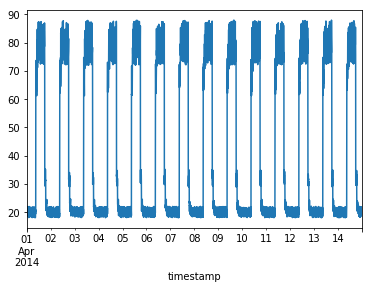

In [5]:
#正常的时序数据可视化
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

**带有异常的时序数据如下：**

异常时序数据的作用是待训练好模型后，将使用以下数据进行测试，并查看数据中的突然跳升是否被检测为异常。

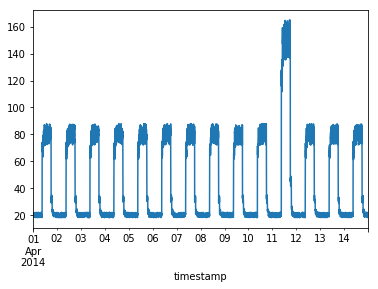

In [6]:
#异常的时序数据可视化
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

### 2.3 数据预处理

* 训练数据包含了14天的采样，每天每隔5分钟采集一次数据，所以：
* 每天包含 24 * 60 / 5 = 288 个timestep 
* 总共14天 288 * 14 = 4032 个数据

In [7]:
# 初始化并保存得到的均值和方差，用于初始化数据。
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("训练数据总量:", len(df_training_value))

训练数据总量: 4032


### 2.4 创建 ``Dataset``

从训练数据中创建组合时间步骤为288的连续数据值的序列。


In [8]:
#时序步长
TIME_STEPS = 288    

class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self,data,time_steps):
        """
        步骤二：实现构造函数，定义数据读取方式，划分训练和测试数据集
        注意：这个是不需要label
        """
        super(MyDataset, self).__init__()
        self.time_steps = time_steps
        self.data = paddle.to_tensor(self.transform(data), dtype='float32')

    def transform(self,data):
        '''
        构造时序数据
        '''
        output = []
        for i in range(len(data) - self.time_steps):
            output.append(np.reshape(data[i : (i + self.time_steps)], (1,self.time_steps)))
        return np.stack(output)

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据）
        """
        data = self.data[index]
        label = self.data[index]
        return data, label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.data)

# 实例化数据集
train_dataset = MyDataset(df_training_value.values, TIME_STEPS)

## 三、模型组网

接下来是构建``AutoEncoder``模型，本示例使用 ``paddle.nn`` 下的API，``Layer、Conv1D、Conv1DTranspose、relu``，采用 ``SubClass`` 的方式完成网络的搭建。

In [9]:
class AutoEncoder(paddle.nn.Layer):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv0 = paddle.nn.Conv1D(in_channels=1,out_channels=32,kernel_size=7,stride=2)
        self.conv1 = paddle.nn.Conv1D(in_channels=32,out_channels=16,kernel_size=7,stride=2)
        self.convT0 = paddle.nn.Conv1DTranspose(in_channels=16,out_channels=32,kernel_size=7,stride=2)
        self.convT1 = paddle.nn.Conv1DTranspose(in_channels=32,out_channels=1,kernel_size=7,stride=2)

    def forward(self, x):
        x = self.conv0(x)
        x = F.relu(x)
        x = F.dropout(x,0.2)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.convT0(x)
        x = F.relu(x)
        x = F.dropout(x,0.2)
        x = self.convT1(x)
        return x

## 四、模型训练

接下来，用一个循环来进行模型的训练，将会：

- 使用 ``paddle.optimizer.Adam`` 优化器来进行优化。

- 使用 ``paddle.nn.MSELoss`` 来计算损失值。 

- 使用 ``paddle.io.DataLoader`` 来实现数据加载。


100%|██████████| 200/200 [00:53<00:00,  3.77it/s]


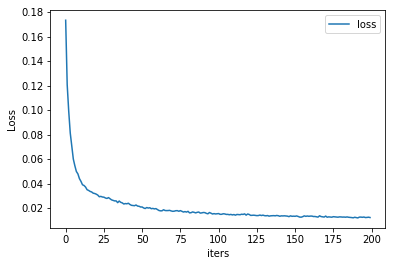

In [11]:
import tqdm
# 参数设置
epoch_num = 200
batch_size = 128
learning_rate = 0.001

def train():
    print('训练开始')
    # 实例化模型
    model = AutoEncoder()
    # 将模型转换为训练模式
    model.train()
    # 设置优化器，学习率，并且把模型参数给优化器
    opt = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=model.parameters())
    # 设置损失函数
    mse_loss = paddle.nn.MSELoss()
    # 设置数据读取器
    data_reader = paddle.io.DataLoader(train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)
    history_loss = []
    iter_epoch = []
    for epoch in tqdm.tqdm(range(epoch_num)):
        for batch_id, data in enumerate(data_reader()):             
            x = data[0]
            y = data[1]
            out = model(x)
            avg_loss = mse_loss(out,(y[:,:,:-1]))   # 输入的数据经过卷积会丢掉最后一个数据
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
        iter_epoch.append(epoch)
        history_loss.append(avg_loss.numpy()[0])
    # 绘制loss
    plt.plot(iter_epoch,history_loss, label = 'loss')
    plt.legend()
    plt.xlabel('iters')
    plt.ylabel('Loss')
    plt.show()
    # 保存模型参数
    paddle.save(model.state_dict(),'model')

train()

## 五、模型预测：探测异常时序

用训练好的模型探测异常时序：

1. 使用自编码器计算出无异常时序数据集里的所有重建损失

2. 找出最大重建损失并且以这个为阀值，模型重建损失超出这个值则输入的数据为异常时序 



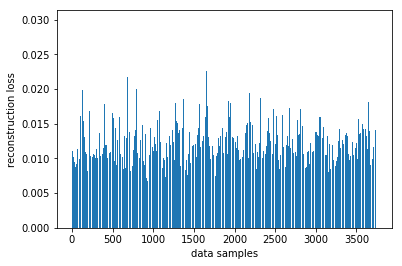

阀值: 0.029842736


In [12]:
# 计算阀值

param_dict = paddle.load('model')   # 读取保存的参数
model = AutoEncoder()    
model.load_dict(param_dict)    # 加载参数
model.eval()   # 预测
total_loss = []
datas = []
# 预测所有正常时序
mse_loss = paddle.nn.loss.MSELoss()
# 这里设置batch_size为1，单独求得每个数据的loss
data_reader = paddle.io.DataLoader(train_dataset,
                        places=[paddle.CPUPlace()],
                        batch_size=1,
                        shuffle=False,
                        drop_last=False,
                        num_workers=0)
for batch_id, data in enumerate(data_reader()):
    x = data[0]
    y = data[1]
    out = model(x)
    avg_loss = mse_loss(out,(y[:,:,:-1]))
    total_loss.append(avg_loss.numpy()[0])
    datas.append(batch_id)

plt.bar(datas, total_loss)
plt.ylabel("reconstruction loss")
plt.xlabel("data samples")
plt.show()

# 获取重建loss的阀值
threshold = np.max(total_loss)
print("阀值:", threshold)

## 六、AutoEncoder 对异常数据的重构

为了有趣，先看看模型是如何重构第一个组数据。这是训练数据集第一天起的288步时间。

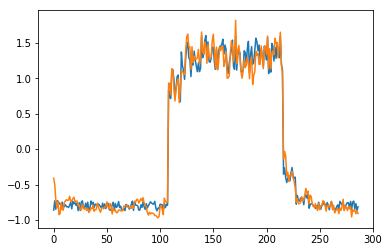

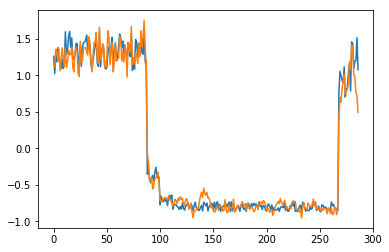

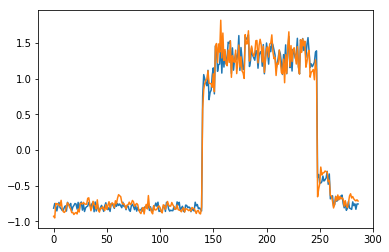

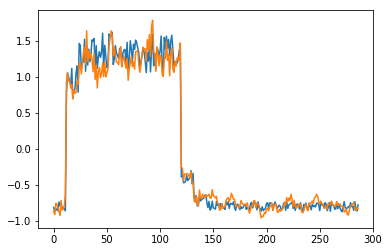

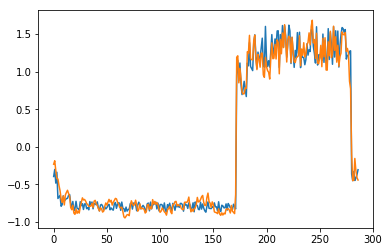

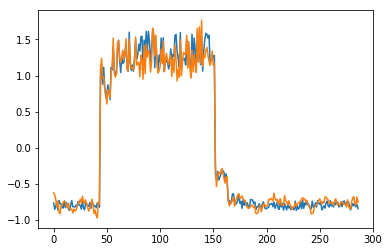

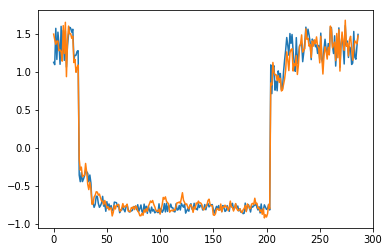

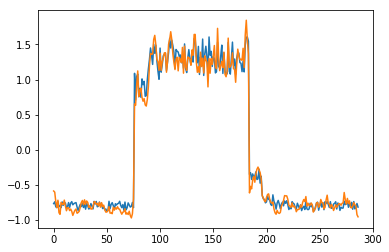

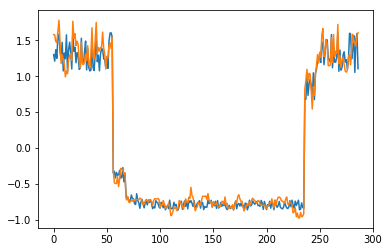

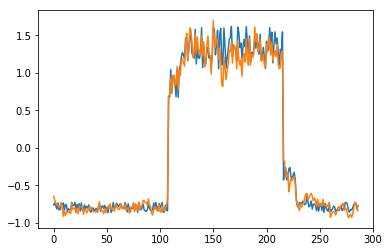

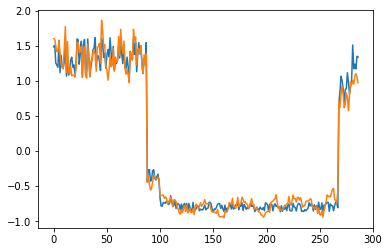

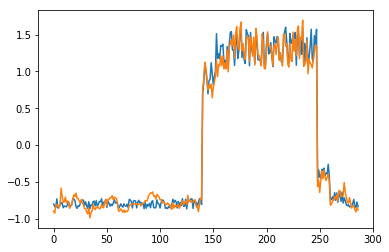

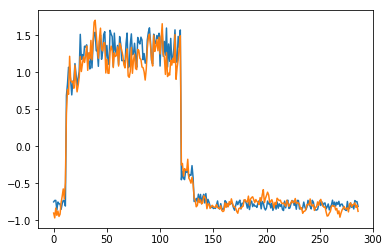

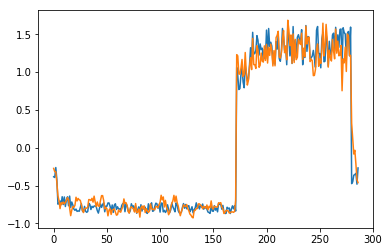

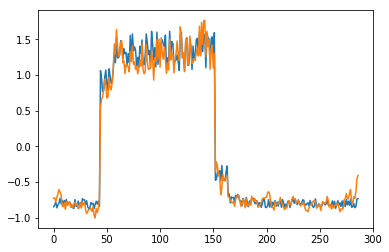

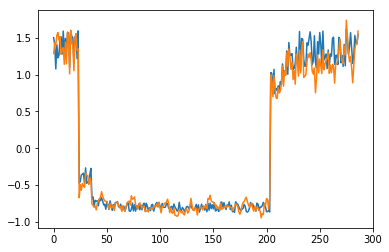

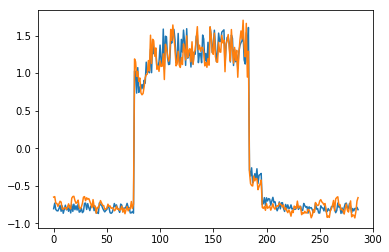

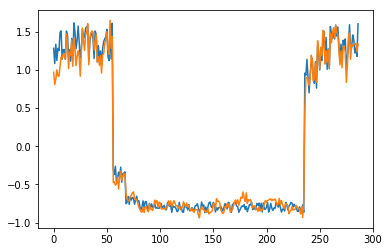

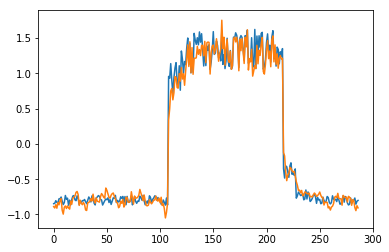

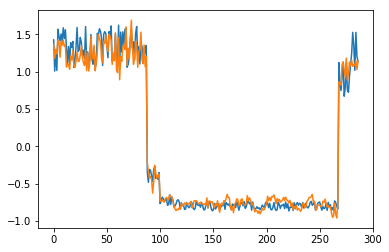

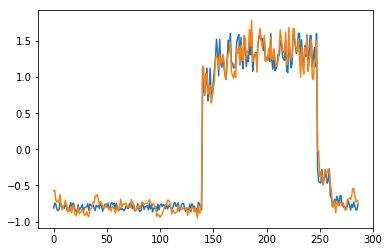

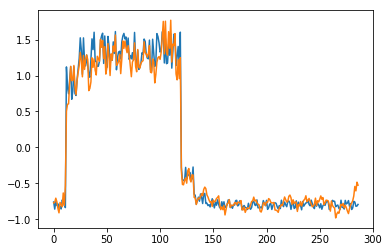

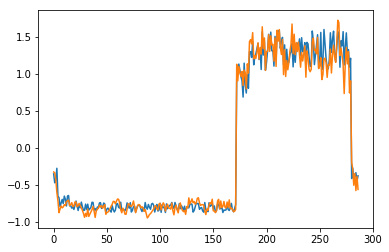

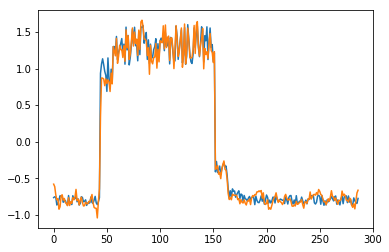

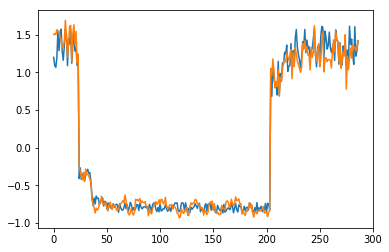

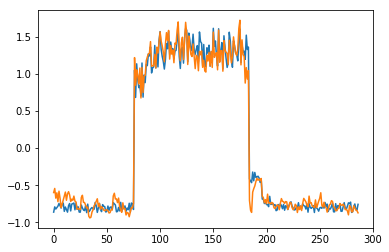

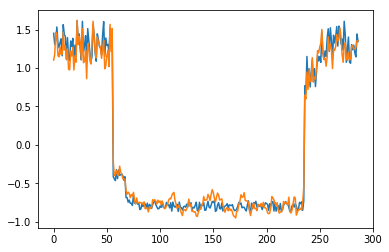

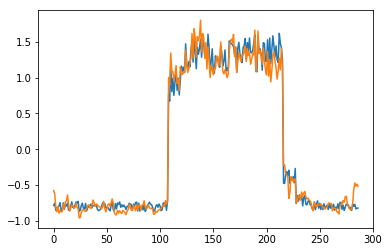

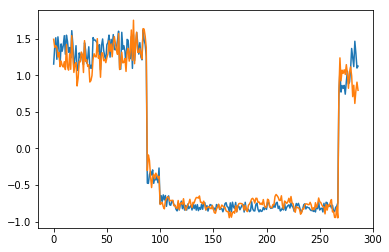

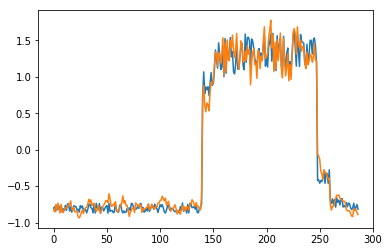

In [13]:
import sys
param_dict = paddle.load('model')   # 读取保存的参数
model = AutoEncoder()    
model.load_dict(param_dict)    # 加载参数
model.eval()   # 预测
data_reader = paddle.io.DataLoader(train_dataset,
                        places=[paddle.CPUPlace()],
                        batch_size=128,
                        shuffle=False,
                        drop_last=False,
                        num_workers=0)
for batch_id, data in enumerate(data_reader()):
    x = data[0]
    out = model(x)
    step = np.arange(287)
    plt.plot(step,x[0,0,:-1].numpy())
    plt.plot(step,out[0,0].numpy())
    plt.show()
    sys.exit


* 可以看出对正常数据的重构效果十分不错
* 接下来对异常数据进行探测

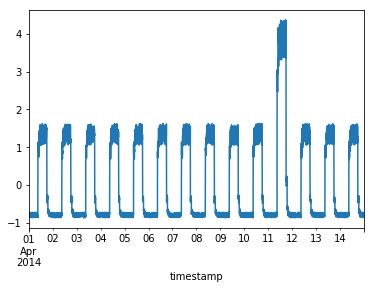

In [15]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()
# 这是测试集里面的异常数据，可以看到第11~~12天发生了异常

In [ ]:
# 探测异常数据
threshold = 0.033    # 阀值设定，即刚才求得的值
param_dict = paddle.load('model')   # 读取保存的参数
model = AutoEncoder()    
model.load_dict(param_dict)    # 加载参数
model.eval()   # 预测
mse_loss = paddle.nn.loss.MSELoss()

def create_sequences(values, time_steps=288):
    '''
    探测数据预处理
    '''
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_test = create_sequences(df_test_value.values)
x = paddle.to_tensor(x_test).astype('float32')

abnormal_index = [] # 记录检测到异常时数据的索引

for i in range(len(x_test)):
    input_x = paddle.reshape(x[i],(1,1,288))
    out = model(input_x)
    loss = mse_loss(input_x[:,:,:-1],out)
    if loss.numpy()[0]>threshold:
        # 开始检测到异常时序列末端靠近异常点，所以要加上序列长度，得到真实索引位置
        abnormal_index.append(i+288)

# 不再检测异常时序列的前端靠近异常点，所以要减去索引长度得到异常点真实索引，为了结果明显，给异常位置加宽40单位
abnormal_index = abnormal_index[:(-288+40)]
print(len(abnormal_index))
print(abnormal_index)

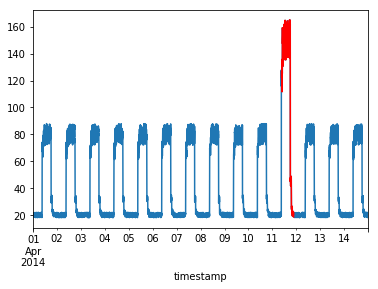

In [ ]:
# 异常检测结果可视化
df_subset = df_daily_jumpsup.iloc[abnormal_index]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()